In [384]:
import os

current_dir = os.getcwd()

mitsuba_file = os.path.join(
    current_dir,
    "central_park",
    "central_park.xml",
)

In [385]:
import drjit as dr
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")

scene = mi.load_file(mitsuba_file)

params = mi.traverse(scene)
print(params)

SceneParameters[
  ------------------------------------------------------------------------------------------------
  Name                                         Flags    Type  Parent
  ------------------------------------------------------------------------------------------------
  Camera.near_clip                                      float PerspectiveCamera
  Camera.far_clip                                       float PerspectiveCamera
  Camera.shutter_open                                   float PerspectiveCamera
  Camera.shutter_open_time                              float PerspectiveCamera
  Camera.film.size                                      ScalarVector2u HDRFilm
  Camera.film.crop_size                                 ScalarVector2u HDRFilm
  Camera.film.crop_offset                               ScalarPoint2u HDRFilm
  Camera.x_fov                                 ∂, D     Float PerspectiveCamera
  Camera.to_world                              ∂, D     Transform4f PerspectiveC

In [386]:
# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import os # Configure which GPU
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) # Avoid warnings from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(1) # Set global random seed for reproducibility

In [387]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Paths2CIR

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [388]:
# Load integrated scene
scene = load_scene(mitsuba_file)

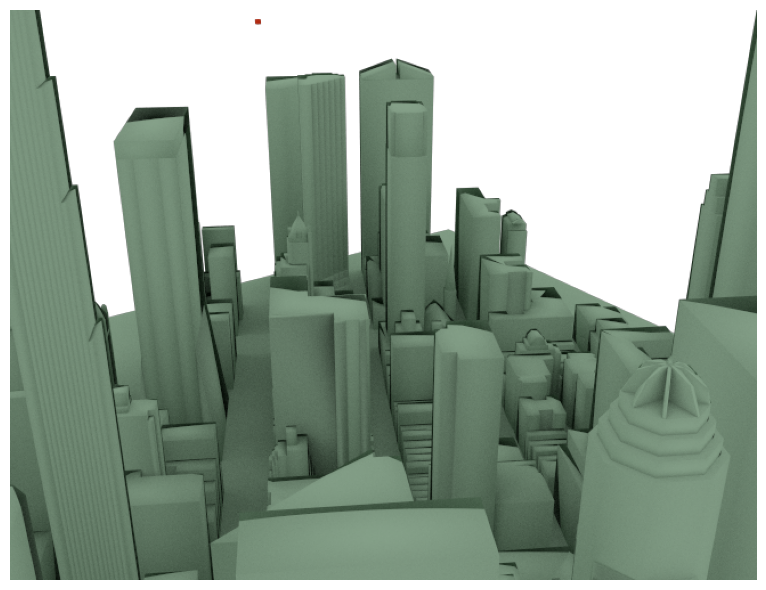

In [389]:
rx_starting_x = -350
rx_starting_y = 200
rx_starting_z = 338.2
cam_angle_x = 250
cam_angle_y = -220
cam_angle_z = 0
# Create new camera with different configuration
my_cam = Camera("my_cam", position=[
    rx_starting_x, 
    rx_starting_y, 
    rx_starting_z],
    look_at=[cam_angle_x,
            cam_angle_y,
            cam_angle_z])
scene.add(my_cam)

scene.render(camera="my_cam", num_samples=512);
    

In [390]:
# scene.preview()